In [1]:
def confidence_intervals(data_line, bootstrap_resamples = 5000):
    """
    input:
    data_line: assumed to be n x t, where n is the number of evaluation runs and t is the number of evaluations periods

    output:
    lines: 3 x t, t is still the number of evaluation periods. First row has lower bound, second row has the mean, third row has the upper bound
    """

    N, T = data_line.shape

    lines = np.zeros((3, T))

    for t in range(T):
        resampled = np.random.choice(
            data_line[:, t],
            size=(bootstrap_resamples, N),
            replace=True
        )
        #print(resampled.shape)
        bootstrapped_means = resampled.mean(axis=1)
        #print(bootstrapped_means)
        #print(bootstrapped_means.shape)

        low, high = np.percentile(bootstrapped_means, [2.5, 97.5])
        #print(low, high)
        lines[0,t] = low
        lines[1,t] = np.mean(data_line[:,t])
        lines[2,t] = high

    return lines

def extracts_from_traces(list_of_traces):
    """
    Assuming traces is a list of dictonairies
    """
    #list_of_traces is T long, where T is the number of evaluation periods
    T = len(list_of_traces)
    #Every dictonairy has N keys, where N is the number of evaluation runs
    N = len(list_of_traces[0].keys())
    for t, traces in enumerate(list_of_traces):
        for i, key in enumerate(traces.keys()):
            trace = traces[key]

            length_episode = len(trace["actions"])
            accumalitive_reward = trace["rewards"].sum()
            average_reward_per_step_episode = accumalitive_reward / length_episode
            mc_reward = trace["mc_return"].avg() #What is this
            success = trace["reward"][-1]>50
            collision = trace["reward"][-1]<50
            max_steps = not(success or collision)

            #store in data_matrix[i,t], #maybe a dictonairy that stores all datamatrices?

    #For all datamatrices
    #plot_data confidence_intervals(data_matrix)

    #Maybe store all plot data in one dictonairy


In [2]:
import os
import pickle
import re
import numpy as np
import time
import matplotlib.pyplot as plt

#from PSRL---AlphaZero-implementation import MCTS_AC
#path_psrl_map = r"C:\Users\svenr\OneDrive - KTH\Exchange\Provably safe reinforcement learning\rl-comptetition\PSRL---AlphaZero-implementation"
#os.chdir(path_psrl_map)
import MCTS

In [3]:
print(os.getcwd())

C:\Users\svenr\OneDrive - KTH\Exchange\Provably safe reinforcement learning\rl-comptetition\PSRL---AlphaZero-implementation


In [4]:
#Put your path here
path = r"C:\Users\svenr\OneDrive - KTH\Exchange\Provably safe reinforcement learning\rl-comptetition\PSRL---AlphaZero-implementation\slim"
os.chdir(path)
items = os.listdir(".")
print(items)

['ckpt_3D_exploration_AC_stepwise_base_ckpt_step_000020000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_base_ckpt_step_000040000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_base_ckpt_step_000060000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_base_ckpt_step_000080000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_base_ckpt_step_000100000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_base_ckpt_step_000120000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_base_ckpt_step_000140000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_base_ckpt_step_000160000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_base_ckpt_step_000180000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_base_ckpt_step_000200000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_biggernet_ckpt_step_000020000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_biggernet_ckpt_step_000040000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_biggernet_ckpt_step_000060000_slim.pkl', 'ckpt_3D_exploration_AC_stepwise_biggernet_ckpt_step_000080000_slim.pkl', 'ckpt_3D_expl

In [40]:
data_for_plots = {}
T = 10


start_time = time.time()
last_time = time.time()


for item_number, item in enumerate(items):
    print(f"Unpacking traces {item_number + 1} out of {len(items)}")
    new_time = time.time()
    print(f"start unpacking after {new_time-last_time} seconds, time since start is {new_time-start_time} seconds")
    last_time = new_time
    
    with open(item, "rb") as f:
        data = pickle.load(f)
    new_time = time.time()
    print(f"done unpacking after {new_time-last_time} seconds, time since start is {new_time-start_time} seconds")
    last_time = new_time
    
    checkpoint = data['checkpoint']
    bin_number = int(re.search(r"\d+", checkpoint).group()) 
    index = bin_number//20000 -1 
    new_time = time.time()
    print(f"start making new dicts after {new_time-last_time} seconds, time since start is {new_time-start_time} seconds")
    last_time = new_time
    
    key_run = data["run"]
    traces = data["traces"]
    if key_run not in data_for_plots.keys():
        #Run not yet in data. Initiate new matrices
        data_for_plots[key_run] = {}
        N = len(traces.keys())
        episode_accumalated_returns = np.zeros((N,T))
        length_episode = np.zeros((N,T))
        average_reward_per_step_episode = np.zeros((N,T))
        successes = np.zeros((N,T))
        collisions = np.zeros((N,T))
        non_terminal = np.zeros((N,T))
        
        run_data= data_for_plots[key_run]
        run_data["Episode accumalated returns"] = episode_accumalated_returns
        run_data["Length episodes"] = length_episode
        run_data["Average reward per timestep"] = average_reward_per_step_episode
        run_data["Success %"] = successes
        run_data["Fail %"] = collisions *100
        run_data["No termination %"] = non_terminal * 100

    new_time = time.time()
    print(f"start filling new runs after {new_time-last_time} seconds, time since start is {new_time-start_time} seconds")
    last_time = new_time
    run_data= data_for_plots[key_run]
    for i, key in enumerate(traces.keys()):
        trace = traces[key]
        length_episode = len(trace["rewards"])
        run_data["Length episodes"][i,index] = length_episode
        accumalitive_reward= sum(trace["rewards"])    
        run_data["Episode accumalated returns"][i,index] = accumalitive_reward
        run_data["Average reward per timestep"][i,index] = accumalitive_reward / length_episode
        success = trace["rewards"][-1] > 50
        collision = trace["rewards"][-1] < -50
        run_data["Success %"][i,index] = success * 100
        run_data["Fail %"][i,index] = collision * 100
        run_data["No termination %"][i,index] = (not (success or collision)) *100


    new_time = time.time()
    print(f"done filling new runs after {new_time-last_time} seconds, time since start is {new_time-start_time} seconds")
    last_time = new_time


Unpacking traces 1 out of 50
start unpacking after 0.0010151863098144531 seconds, time since start is 0.0010151863098144531 seconds
done unpacking after 0.0018529891967773438 seconds, time since start is 0.002868175506591797 seconds
start making new dicts after 0.0 seconds, time since start is 0.002868175506591797 seconds
start filling new runs after 0.0 seconds, time since start is 0.002868175506591797 seconds
done filling new runs after 0.0 seconds, time since start is 0.002868175506591797 seconds
Unpacking traces 2 out of 50
start unpacking after 0.0 seconds, time since start is 0.002868175506591797 seconds
done unpacking after 0.009759187698364258 seconds, time since start is 0.012627363204956055 seconds
start making new dicts after 0.0 seconds, time since start is 0.012627363204956055 seconds
start filling new runs after 0.002011537551879883 seconds, time since start is 0.014638900756835938 seconds
done filling new runs after 0.0 seconds, time since start is 0.014638900756835938 s

In [41]:
def ylim_mapping(plot):
    if plot == "Episode accumalated returns":
        return plt.ylim(-10,210)
    elif plot == "Success %" or plot == "Fail %" or plot =="No termination %":
        return plt.ylim(-5,105)
    elif plot == "Length episodes":
        return plt.ylim(-10,160)

In [42]:
print(data_for_plots.keys())

dict_keys(['ckpt_3D_exploration_AC_stepwise_base', 'ckpt_3D_exploration_AC_stepwise_biggernet', 'ckpt_3D_exploration_AC_stepwise_cpuct05', 'ckpt_3D_exploration_AC_stepwise_gamma095', 'ckpt_3D_exploration_AC_stepwise_numsim400'])


In [43]:
def label_mapping(run):
    #if run == """ :
    #    return ""
    #elif :
    return run

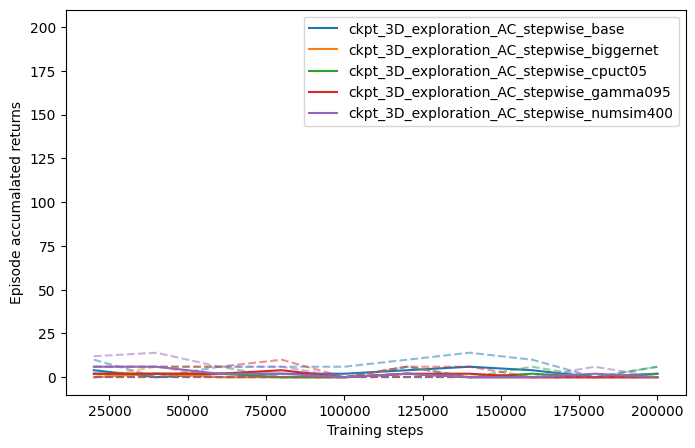

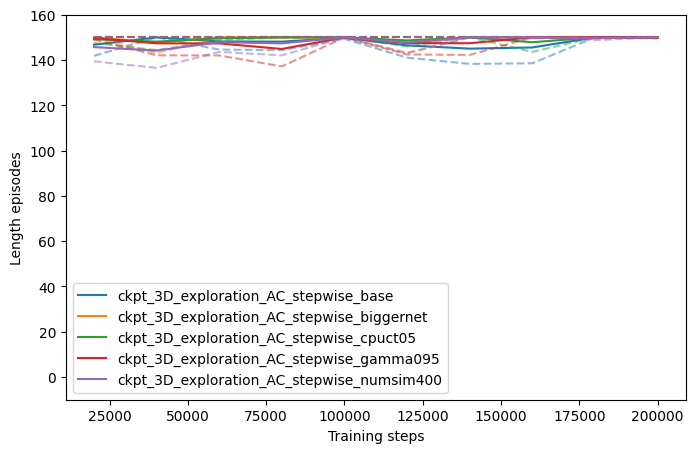

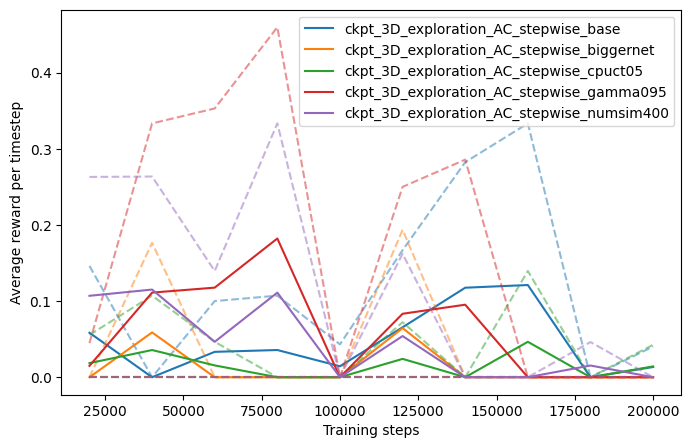

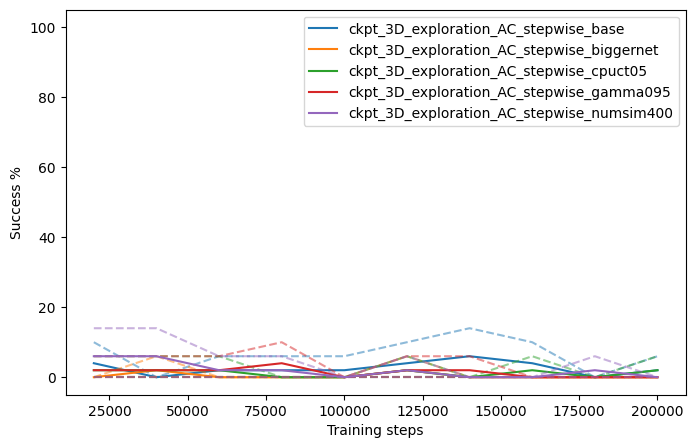

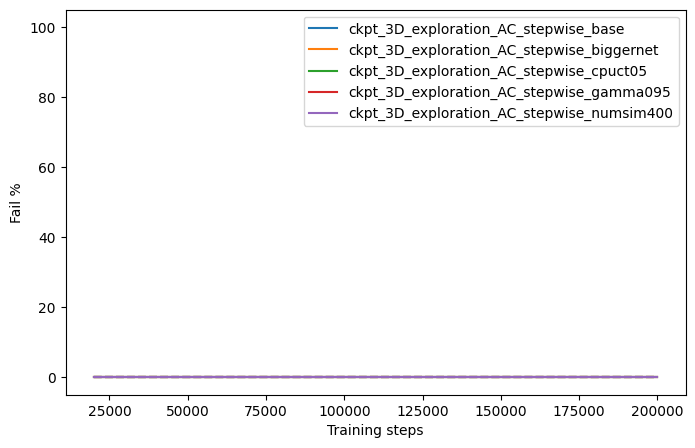

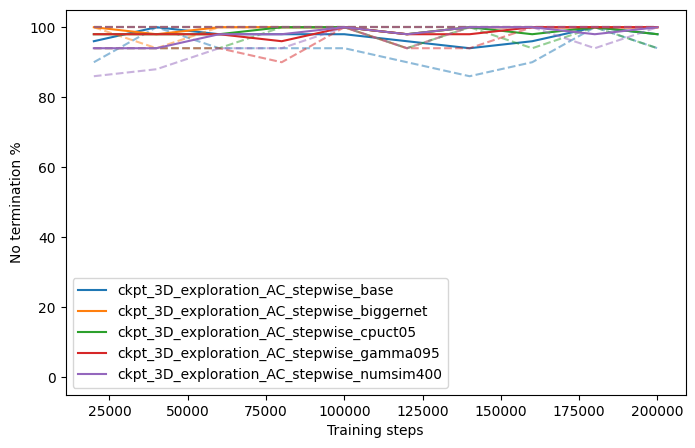

In [45]:
plot_list = data_for_plots[list(data_for_plots.keys())[0]].keys()
training_steps = np.array([20000 * (i + 1) for i in range(T)])


for plot in plot_list:
    plt.figure(figsize=(8,5))
    #plt.title(plot)
    plt.xlabel("Training steps")
    plt.ylabel(plot)
    #In this for loop I am collecting data from different runs that need to go in the same loop
    #Do chatgpt: the three lines from 1 run should be the same colo
    for run_idx, run in enumerate(data_for_plots.keys()):
        run_data = data_for_plots[run]
        lines_to_plot = confidence_intervals(run_data[plot])
        #Do chatgpt: lines_to_plot contains a matrix with 3 rows. The lines at rows 0 and 2 should be striped and row 1 solid
        #episodes = np.arange(lines_to_plot.shape[1])

        # Row 0: lower bound (striped)
        plt.plot(training_steps, lines_to_plot[0], linestyle='--', color=f"C{run_idx}", alpha=0.5)
        # Row 1: mean (solid)
        plt.plot(training_steps, lines_to_plot[1], linestyle='-', color=f"C{run_idx}", label=label_mapping(run))
        # Row 2: upper bound (striped)
        plt.plot(training_steps, lines_to_plot[2], linestyle='--', color=f"C{run_idx}", alpha=0.5)
    
    ylim_mapping(plot)
    plt.legend()
    plt.show()